# Masalah yang Ingin Diselesaikan

Dalam era digital saat ini, kebutuhan akan alat bantu penulisan yang cerdas semakin meningkat, terutama untuk para pelajar, peneliti, dan profesional yang sering menulis dalam bahasa Inggris. Salah satu tantangan utama adalah menghasilkan variasi kalimat yang bermakna sama (paraphrasing) untuk menghindari plagiarisme, memperbaiki struktur kalimat, atau menyederhanakan bahasa tanpa mengubah makna inti. Namun, proses parafrase manual memakan waktu dan tidak selalu menghasilkan kalimat yang natural. Oleh karena itu, kami ingin mengembangkan sebuah model paraphraser otomatis berbasis deep learning untuk bahasa Inggris yang mampu menghasilkan kalimat baru dengan makna yang setara dari input pengguna.

# Sumber Data dan Deskripsi Data

**Dataset Quora Question Pairs**  
(https://www.kaggle.com/competitions/quora-question-pairs/data)  
Dataset ini berisi lebih dari 400.000 pasang pertanyaan dalam bahasa Inggris yang memiliki makna serupa namun dengan formulasi kalimat yang berbeda. Setiap entri terdiri dari dua pertanyaan dan label apakah keduanya memiliki makna yang sama (`is_duplicate`). Dataset ini sangat relevan untuk tugas parafrase karena menyediakan banyak contoh kalimat dengan makna yang setara namun struktur kalimat yang berbeda.

**Dataset PAWS (Paraphrase Adversaries from Word Scrambling)**  
(https://github.com/google-research-datasets/paws)  
Dataset ini berisi pasangan kalimat dengan tingkat kemiripan kata tinggi namun makna yang bisa sama atau berbeda. Dataset ini akan membantu model membedakan antara parafrase yang benar dan sekadar kemiripan kata.

# Pemodelan yang Akan Digunakan

Kami akan mengeksplorasi dua pendekatan utama dalam pemodelan:

1. **Transformer-based Models:**  
   Menggunakan model pretrained seperti BERT atau T5 untuk melakukan fine-tuning pada dataset parafrase yang telah dipilih.

Evaluasi model akan dilakukan menggunakan metrik BLEU, ROUGE, dan METEOR untuk mengukur kualitas parafrase yang dihasilkan dibandingkan dengan kalimat referensi.

# Import Library

Import library yang diperlukan untuk pemrosesan data, deep learning, dan evaluasi.

In [1]:
# Import library utama
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import transformers
import tensorflow as tf
import nltk
from sklearn.model_selection import train_test_split
import re
from transformers import T5Tokenizer,  T5ForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq

# Cek versi library utama
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("torch:", torch.__version__)
print("transformers:", transformers.__version__)
print("tensorflow:", tf.__version__)
print("nltk:", nltk.__version__)

numpy: 2.0.2
pandas: 2.2.2
torch: 2.6.0+cu124
transformers: 4.51.3
tensorflow: 2.18.0
nltk: 3.9.1


# Eksplorasi Data Awal (EDA)

Pada tahap ini, kita akan melakukan eksplorasi data awal pada dataset Quora Question Pairs untuk memahami struktur data, distribusi label, dan contoh data. EDA penting untuk memastikan kualitas data sebelum masuk ke tahap pemodelan.

In [2]:
#!/bin/bash
!curl -L -o ./question-pairs-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/quora/question-pairs-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 20.7M  100 20.7M    0     0  5252k      0  0:00:04  0:00:04 --:--:-- 8809k


In [3]:
!unzip question-pairs-dataset.zip -d ./

Archive:  question-pairs-dataset.zip
  inflating: ./questions.csv         


In [4]:
!curl -L -o paws_wiki_labeled_final.tar.gz https://storage.googleapis.com/paws/english/paws_wiki_labeled_final.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4577k  100 4577k    0     0  1709k      0  0:00:02  0:00:02 --:--:-- 1709k


In [5]:
!tar -xvzf paws_wiki_labeled_final.tar.gz

final/test.tsv
final/
final/train.tsv
final/dev.tsv


In [6]:
# Quora Question Pairs
# Path ke file
file_path = 'questions.csv'

# Membaca file CSV
df = pd.read_csv(file_path)

# Tampilkan isi
print(df.head())


# PAWS
# Load dataset PAWS
paws_train_path = 'final/train.tsv'
paws_dev_path = 'final/dev.tsv'
paws_test_path = 'final/test.tsv'

# Membaca file TSV PAWS
paws_train = pd.read_csv(paws_train_path, sep='\t')
paws_dev = pd.read_csv(paws_dev_path, sep='\t')
paws_test = pd.read_csv(paws_test_path, sep='\t')


   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


In [7]:
# Tampilkan informasi dasar dataset
print("Informasi Dataset:")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")
print("\nNama kolom:")
print(df.columns.tolist())

# Tampilkan beberapa baris pertama
print("\nContoh data:")
display(df.head())

# Cek nilai yang hilang
print("\nNilai yang hilang per kolom:")
print(df.isnull().sum())

# Distribusi label duplikat
print("\nDistribusi label is_duplicate:")
print(df['is_duplicate'].value_counts())
print(f"Persentase duplikat: {df['is_duplicate'].mean() * 100:.2f}%")

Informasi Dataset:
Jumlah baris: 404351
Jumlah kolom: 6

Nama kolom:
['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']

Contoh data:


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0



Nilai yang hilang per kolom:
id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

Distribusi label is_duplicate:
is_duplicate
0    255045
1    149306
Name: count, dtype: int64
Persentase duplikat: 36.92%


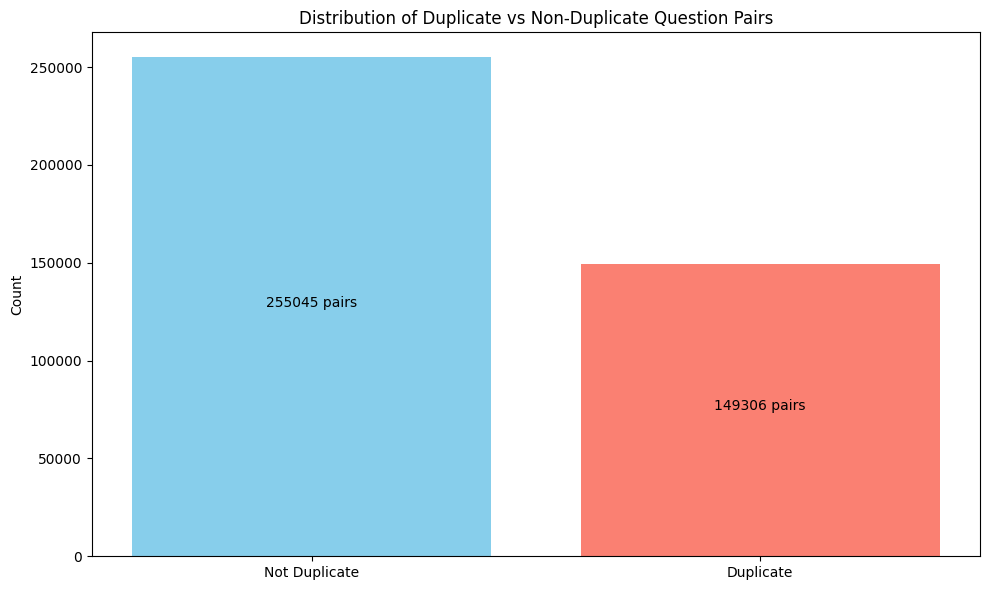

<ipython-input-8-22589d8bfc54>:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['len_q1'], df['len_q2']], labels=['Question 1', 'Question 2'])


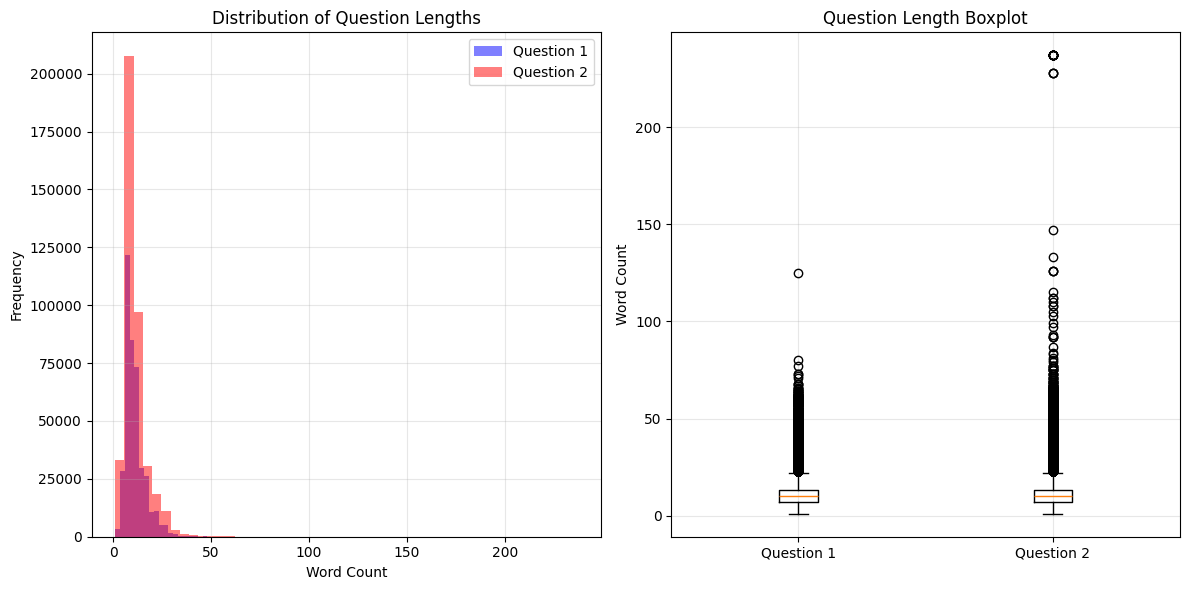


Statistik panjang pertanyaan (jumlah kata):


,Question 1,Question 2
count,404351.000000,404351.000000
mean,10.941773,11.181130
std,5.428716,6.305343
min,1.000000,1.000000
25%,7.000000,7.000000
50%,10.000000,10.000000
75%,13.000000,13.000000
max,125.000000,237.000000


In [8]:
# Visualisasi distribusi label
plt.figure(figsize=(10, 6))
counts = df['is_duplicate'].value_counts()
plt.bar(['Not Duplicate', 'Duplicate'], counts.values, color=['skyblue', 'salmon'])
plt.title('Distribution of Duplicate vs Non-Duplicate Question Pairs')
plt.ylabel('Count')
plt.annotate(f"{counts[0]} pairs", (0, counts[0]/2), ha='center')
plt.annotate(f"{counts[1]} pairs", (1, counts[1]/2), ha='center')
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

# Analisis panjang pertanyaan
df['len_q1'] = df['question1'].apply(lambda x: len(str(x).split()))
df['len_q2'] = df['question2'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['len_q1'], bins=50, alpha=0.5, color='blue', label='Question 1')
plt.hist(df['len_q2'], bins=50, alpha=0.5, color='red', label='Question 2')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Question Lengths')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([df['len_q1'], df['len_q2']], labels=['Question 1', 'Question 2'])
plt.ylabel('Word Count')
plt.title('Question Length Boxplot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistik deskriptif panjang pertanyaan
print("\nStatistik panjang pertanyaan (jumlah kata):")
length_stats = pd.DataFrame({
    'Question 1': df['len_q1'].describe(),
    'Question 2': df['len_q2'].describe()
})
display(length_stats)

# Penggabungan Dataset Quora dan PAWS

Untuk memperkaya data pelatihan model paraphraser, kita akan menggabungkan dataset Quora Question Pairs dan PAWS. Kedua dataset memiliki karakteristik yang melengkapi satu sama lain:

1. **Dataset Quora**: Berisi pasangan pertanyaan yang memiliki makna serupa dengan variasi formulasi kalimat yang alami.
2. **Dataset PAWS**: Berisi pasangan kalimat dengan tingkat kemiripan kata tinggi namun bisa memiliki makna yang sama atau berbeda.

Penggabungan ini akan membantu model belajar menghasilkan parafrasa yang lebih beragam dan robust.

In [9]:
# Menggabungkan dataset PAWS
paws_df = pd.concat([paws_train, paws_dev, paws_test], ignore_index=True)

# Menampilkan informasi awal PAWS
print("Dataset PAWS:")
print(f"Jumlah baris: {paws_df.shape[0]}")
print(f"Jumlah kolom: {paws_df.shape[1]}")
print("\nNama kolom PAWS:")
print(paws_df.columns.tolist())

# Tampilkan beberapa baris pertama
print("\nContoh data PAWS:")
display(paws_df.head())

# Distribusi label pada PAWS
print("\nDistribusi label pada PAWS:")
print(paws_df['label'].value_counts())
print(f"Persentase paraphrase: {paws_df['label'].mean() * 100:.2f}%")

Dataset PAWS:
Jumlah baris: 65401
Jumlah kolom: 4

Nama kolom PAWS:
['id', 'sentence1', 'sentence2', 'label']

Contoh data PAWS:


,id,sentence1,sentence2,label
0,1,"In Paris , in October 1560 , he secretly met t...","In October 1560 , he secretly met with the Eng...",0
1,2,The NBA season of 1975 -- 76 was the 30th seas...,The 1975 -- 76 season of the National Basketba...,1
2,3,"There are also specific discussions , public p...","There are also public discussions , profile sp...",0
3,4,When comparable rates of flow can be maintaine...,The results are high when comparable flow rate...,1
4,5,It is the seat of Zerendi District in Akmola R...,It is the seat of the district of Zerendi in A...,1



Distribusi label pada PAWS:
label
0    36497
1    28904
Name: count, dtype: int64
Persentase paraphrase: 44.20%


In [10]:
# Mengubah format PAWS agar sesuai dengan format Quora
paws_reformatted = pd.DataFrame({
    'id': paws_df['id'],
    'question1': paws_df['sentence1'],
    'question2': paws_df['sentence2'],
    'is_duplicate': paws_df['label']
})

# Pilih hanya kolom yang akan digunakan dalam merger
quora_subset = df[['question1', 'question2', 'is_duplicate']]
paws_subset = paws_reformatted[['question1', 'question2', 'is_duplicate']]

# Tambahkan kolom source untuk tracking
quora_subset['source'] = 'quora'
paws_subset['source'] = 'paws'

# Gabungkan kedua dataset
merged_df = pd.concat([quora_subset, paws_subset], ignore_index=True)

# Tampilkan informasi dataset gabungan
print("Dataset Gabungan (Quora + PAWS):")
print(f"Jumlah baris total: {merged_df.shape[0]}")
print(f"Jumlah baris dari Quora: {quora_subset.shape[0]}")
print(f"Jumlah baris dari PAWS: {paws_subset.shape[0]}")

# Distribusi label pada dataset gabungan
print("\nDistribusi label pada dataset gabungan:")
print(merged_df['is_duplicate'].value_counts())
print(f"Persentase duplikat: {merged_df['is_duplicate'].mean() * 100:.2f}%")

# Distribusi berdasarkan sumber dataset
print("\nDistribusi berdasarkan sumber dataset:")
print(merged_df['source'].value_counts())

# Tampilkan beberapa contoh dari dataset gabungan
print("\nContoh data dari dataset gabungan:")
display(merged_df.sample(5))

Dataset Gabungan (Quora + PAWS):
Jumlah baris total: 469752
Jumlah baris dari Quora: 404351
Jumlah baris dari PAWS: 65401

Distribusi label pada dataset gabungan:
is_duplicate
0    291542
1    178210
Name: count, dtype: int64
Persentase duplikat: 37.94%

Distribusi berdasarkan sumber dataset:
source
quora    404351
paws      65401
Name: count, dtype: int64

Contoh data dari dataset gabungan:


<ipython-input-10-5d23b5dbf4f7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quora_subset['source'] = 'quora'


,question1,question2,is_duplicate,source
112942,Who is the scariest person you have ever met?,Who is the most scariest person you have ever ...,1,quora
220844,How long do you have to be clean from smoking ...,If I stopped smoking meth Sunday at 3 am will ...,1,quora
140307,What is the origin of ISIS?,What is the truth about ISIS?,0,quora
453571,"Even today , the island threatens to divide in...","Even today , the island threatens to divide in...",1,paws
146886,How do I get a girl who doesn't know you like ...,How do you know the girl you like doesn't like...,0,quora


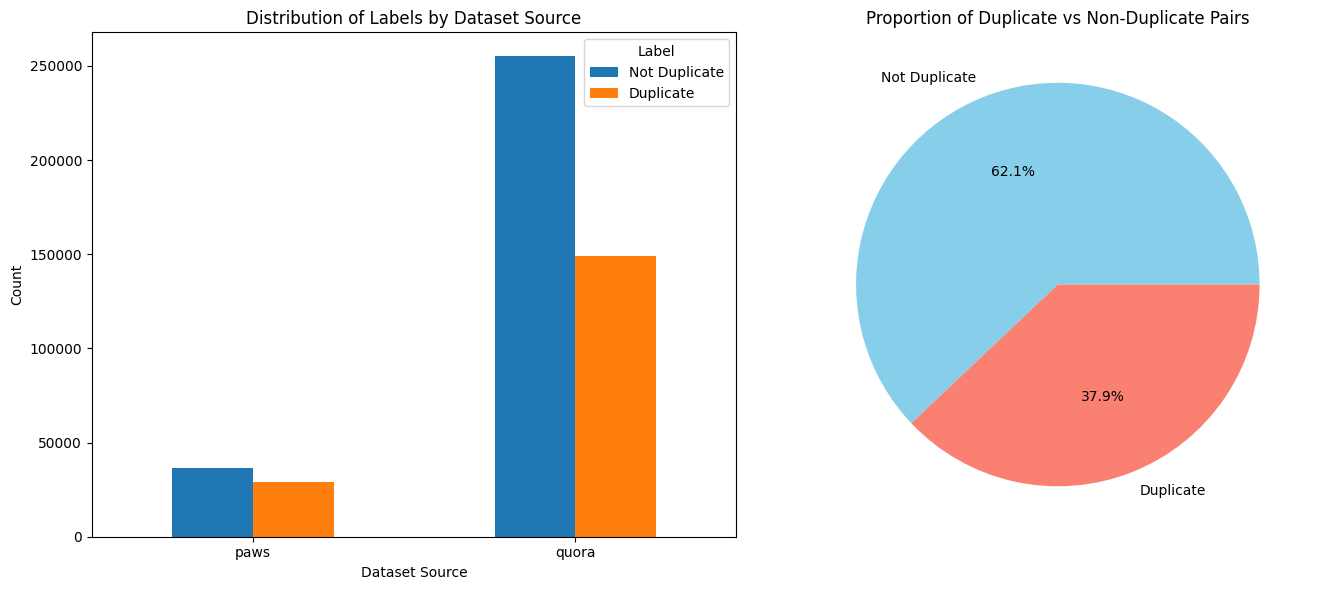

<ipython-input-11-a5accf9c03ea>:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['Quora Q1', 'Quora Q2', 'PAWS Q1', 'PAWS Q2'])


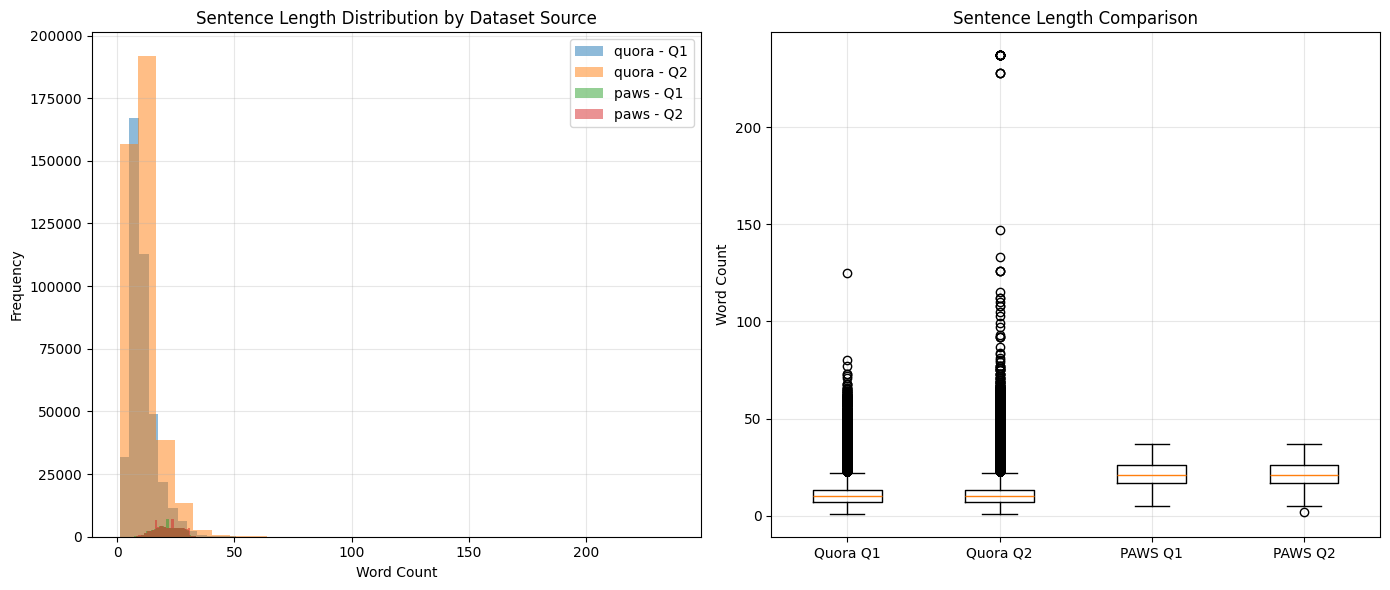

Statistik panjang kalimat berdasarkan sumber dataset:


len_q1                                                       len_q2  \
           count       mean       std  min   25%   50%   75%    max     count   
source                                                                          
paws     65401.0  21.353496  5.474565  5.0  17.0  21.0  26.0   37.0   65401.0   
quora   404351.0  10.941773  5.428716  1.0   7.0  10.0  13.0  125.0  404351.0   

                                                           
             mean       std  min   25%   50%   75%    max  
source                                                     
paws    21.352854  5.464920  2.0  17.0  21.0  26.0   37.0  
quora   11.181130  6.305343  1.0   7.0  10.0  13.0  237.0

In [11]:
# Visualisasi distribusi dataset gabungan
plt.figure(figsize=(14, 6))

# Plot 1: Distribusi label per dataset
plt.subplot(1, 2, 1)
source_label_counts = merged_df.groupby(['source', 'is_duplicate']).size().unstack()
source_label_counts.plot(kind='bar', stacked=False, ax=plt.gca())
plt.title('Distribution of Labels by Dataset Source')
plt.xlabel('Dataset Source')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(['Not Duplicate', 'Duplicate'], title='Label')

# Plot 2: Proporsi duplikat vs non-duplikat
plt.subplot(1, 2, 2)
merged_df['is_duplicate'].value_counts().plot(kind='pie',
                                           autopct='%1.1f%%',
                                           colors=['skyblue', 'salmon'],
                                           labels=['Not Duplicate', 'Duplicate'])
plt.title('Proportion of Duplicate vs Non-Duplicate Pairs')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Analisis panjang kalimat pada dataset gabungan
merged_df['len_q1'] = merged_df['question1'].astype(str).apply(lambda x: len(x.split()))
merged_df['len_q2'] = merged_df['question2'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(14, 6))

# Plot panjang kalimat berdasarkan sumber dataset
plt.subplot(1, 2, 1)
for source in ['quora', 'paws']:
    subset = merged_df[merged_df['source'] == source]
    plt.hist(subset['len_q1'], bins=30, alpha=0.5, label=f'{source} - Q1')
    plt.hist(subset['len_q2'], bins=30, alpha=0.5, label=f'{source} - Q2')

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution by Dataset Source')
plt.legend()
plt.grid(True, alpha=0.3)

# Boxplot perbandingan panjang kalimat
plt.subplot(1, 2, 2)
data_to_plot = [
    merged_df[merged_df['source'] == 'quora']['len_q1'],
    merged_df[merged_df['source'] == 'quora']['len_q2'],
    merged_df[merged_df['source'] == 'paws']['len_q1'],
    merged_df[merged_df['source'] == 'paws']['len_q2']
]
plt.boxplot(data_to_plot, labels=['Quora Q1', 'Quora Q2', 'PAWS Q1', 'PAWS Q2'])
plt.ylabel('Word Count')
plt.title('Sentence Length Comparison')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistik deskriptif panjang kalimat berdasarkan sumber
print("Statistik panjang kalimat berdasarkan sumber dataset:")
source_length_stats = merged_df.groupby('source')[['len_q1', 'len_q2']].describe()
display(source_length_stats)

# Pra-pemrosesan Data

Pada tahap ini, kita akan melakukan pra-pemrosesan data untuk mempersiapkannya untuk model paraphraser. Langkah-langkah pra-pemrosesan meliputi:

1. Menangani nilai yang hilang
2. Menyaring data untuk hanya mengambil pasangan pertanyaan duplikat (untuk training paraphraser)
3. Membersihkan teks (menghapus karakter khusus, normalisasi teks)
4. Membagi data menjadi set pelatihan, validasi, dan pengujian

In [12]:
# Fungsi untuk membersihkan teks
def clean_text(text):
    if isinstance(text, str):
        # Hapus karakter khusus
        text = re.sub(r'[^\w\s]', ' ', text)
        # text = re.sub(r'\d+', ' ', text) # angka
        # Hapus spasi berlebih
        text = re.sub(r'\s+', ' ', text)
        return text.strip().lower()
    else:
        return ""

In [13]:
# Bersihkan dataset gabungan
# Tangani nilai yang hilang
merged_df['question1'] = merged_df['question1'].fillna("")
merged_df['question2'] = merged_df['question2'].fillna("")

# Bersihkan teks dengan fungsi clean_text yang sudah didefinisikan sebelumnya
merged_df['question1_clean'] = merged_df['question1'].apply(clean_text)
merged_df['question2_clean'] = merged_df['question2'].apply(clean_text)

# Filter data untuk pasangan kalimat duplikat untuk pelatihan paraphraser
merged_duplicate_pairs = merged_df[merged_df['is_duplicate'] == 1].copy()
print(f"Jumlah pasangan duplikat dalam dataset gabungan: {merged_duplicate_pairs.shape[0]}")

# Tampilkan contoh dari dataset yang sudah dibersihkan, dibedakan berdasarkan sumber
print("\nContoh pasangan duplikat dari Quora setelah pembersihan:")
display(merged_duplicate_pairs[merged_duplicate_pairs['source'] == 'quora'][['question1_clean', 'question2_clean']].head(3))

print("\nContoh pasangan duplikat dari PAWS setelah pembersihan:")
display(merged_duplicate_pairs[merged_duplicate_pairs['source'] == 'paws'][['question1_clean', 'question2_clean']].head(3))

# Bagi data menjadi set pelatihan, validasi, dan pengujian dengan stratifikasi berdasarkan sumber
# untuk memastikan representasi yang seimbang dari kedua dataset
train_data, temp_data = train_test_split(
    merged_duplicate_pairs,
    test_size=0.2,
    random_state=42,
    stratify=merged_duplicate_pairs['source']
)
val_data, test_data = train_test_split(
    temp_data,
    test_size=0.5,
    random_state=42,
    stratify=temp_data['source']
)

print(f"\nJumlah data training: {train_data.shape[0]}")
print(f"Jumlah data validasi: {val_data.shape[0]}")
print(f"Jumlah data testing: {test_data.shape[0]}")

# Persentase sumber pada setiap split
print("\nPersentase sumber pada data training:")
print(train_data['source'].value_counts(normalize=True) * 100)

print("\nPersentase sumber pada data validasi:")
print(val_data['source'].value_counts(normalize=True) * 100)

print("\nPersentase sumber pada data testing:")
print(test_data['source'].value_counts(normalize=True) * 100)

# Opsional: Simpan dataset gabungan
merged_df.to_csv('quora_paws_merged.csv', index=False)
print("\nDataset gabungan telah disimpan ke 'quora_paws_merged.csv'")

Jumlah pasangan duplikat dalam dataset gabungan: 178210

Contoh pasangan duplikat dari Quora setelah pembersihan:


,question1_clean,question2_clean
5,astrology i am a capricorn sun cap moon and ca...,i m a triple capricorn sun moon and ascendant ...
7,how can i be a good geologist,what should i do to be a great geologist
11,how do i read and find my youtube comments,how can i see all my youtube comments



Contoh pasangan duplikat dari PAWS setelah pembersihan:


,question1_clean,question2_clean
404352,the nba season of 1975 76 was the 30th season ...,the 1975 76 season of the national basketball ...
404354,when comparable rates of flow can be maintaine...,the results are high when comparable flow rate...
404355,it is the seat of zerendi district in akmola r...,it is the seat of the district of zerendi in a...



Jumlah data training: 142568
Jumlah data validasi: 17821
Jumlah data testing: 17821

Persentase sumber pada data training:
source
quora    83.781073
paws     16.218927
Name: proportion, dtype: float64

Persentase sumber pada data validasi:
source
quora    83.783177
paws     16.216823
Name: proportion, dtype: float64

Persentase sumber pada data testing:
source
quora    83.777566
paws     16.222434
Name: proportion, dtype: float64

Dataset gabungan telah disimpan ke 'quora_paws_merged.csv'


# Persiapan Data untuk Model T5

T5 (Text-to-Text Transfer Transformer) adalah model transformer yang dirancang untuk berbagai tugas NLP dengan pendekatan teks-ke-teks. Untuk tugas paraphrasing, kita akan menggunakan T5 dengan format input khusus. Kami akan menyusun data dalam format berikut:

- Input: "paraphrase: [teks asli] </s>"
- Target: "[teks parafrase] </s>"

Model T5 akan dilatih untuk menghasilkan parafrase dari teks asli berdasarkan format ini.

In [14]:
# Persiapan data untuk T5
import random
from torch.utils.data import Dataset

class ParaphraseDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128, prefix="paraphrase: "):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.prefix = prefix

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Secara acak pilih question1 atau question2 sebagai input dan yang lainnya sebagai target
        if np.random.rand() > 0.5:
            input_text = self.dataframe.iloc[idx]['question1_clean']
            target_text = self.dataframe.iloc[idx]['question2_clean']
        else:
            input_text = self.dataframe.iloc[idx]['question2_clean']
            target_text = self.dataframe.iloc[idx]['question1_clean']

        # Tambahkan prefix ke input
        input_text = self.prefix + input_text

        # Tokenisasi input dan target
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        targets = self.tokenizer(
            target_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        input_ids = inputs.input_ids.squeeze()
        attention_mask = inputs.attention_mask.squeeze()
        labels = targets.input_ids.squeeze()

        # Replace padding token id with -100 in labels for loss calculation
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

# Load T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Buat dataset untuk training, validasi, dan testing
train_dataset = ParaphraseDataset(train_data, tokenizer)
val_dataset = ParaphraseDataset(val_data, tokenizer)
test_dataset = ParaphraseDataset(test_data, tokenizer)

print("Dataset berhasil dibuat:")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Contoh data yang diproses
sample_idx = random.randint(0, len(train_dataset) - 1)
sample = train_dataset[sample_idx]
print("\nContoh data yang diproses:")
print("Input IDs shape:", sample["input_ids"].shape)
print("Attention mask shape:", sample["attention_mask"].shape)
print("Labels shape:", sample["labels"].shape)

# Tampilkan contoh input dan target
input_text = tokenizer.decode(sample["input_ids"], skip_special_tokens=False)
target_text = tokenizer.decode([l for l in sample["labels"] if l != -100], skip_special_tokens=False)
print("\nInput text:", input_text)
print("Target text:", target_text)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Dataset berhasil dibuat:
Training dataset size: 142568
Validation dataset size: 17821
Testing dataset size: 17821

Contoh data yang diproses:
Input IDs shape: torch.Size([128])
Attention mask shape: torch.Size([128])
Labels shape: torch.Size([128])

Input text: paraphrase: what is the best phone to buy below 15k</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Target text: which is the best smartphone within 15k</s>


In [ ]:
# Install METEOR package
!pip install -q nltk rouge-score
!pip install -q pycocoevalcap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 8.9 MB/s eta 0:00:00


In [ ]:
# Import METEOR metric
from nltk.translate import meteor_score
import nltk

# Download necessary NLTK resources for METEOR
nltk.download('wordnet')
nltk.download('omw-1.4')

# Custom callback for METEOR score tracking during training
class MeteorScoreCallback(transformers.TrainerCallback):
    def __init__(self, tokenizer, eval_dataset, device, eval_steps=500):
        self.tokenizer = tokenizer
        self.eval_dataset = eval_dataset
        self.device = device
        self.eval_steps = eval_steps
        self.meteor_scores = []
        self.steps = []

    def on_step_end(self, args, state, control, model=None, **kwargs):
        if state.global_step % self.eval_steps == 0 and state.global_step > 0:
            meteor_score = self.calculate_meteor(model)
            self.meteor_scores.append(meteor_score)
            self.steps.append(state.global_step)
            print(f"Step {state.global_step}: METEOR Score = {meteor_score:.4f}")

    def calculate_meteor(self, model, num_samples=50):
        # Sample a subset of evaluation data for METEOR calculation
        indices = np.random.choice(len(self.eval_dataset), min(num_samples, len(self.eval_dataset)), replace=False)

        meteor_scores = []
        model.eval()

        for idx in indices:
            # Get sample from dataset
            sample = self.eval_dataset[idx]
            input_ids = sample["input_ids"].unsqueeze(0).to(self.device)

            # Generate prediction
            with torch.no_grad():
                outputs = model.generate(
                    input_ids=input_ids,
                    max_length=128,
                    num_beams=4,
                    early_stopping=True
                )

            # Decode generated text and reference
            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            reference_text = self.tokenizer.decode([l for l in sample["labels"] if l != -100], skip_special_tokens=True)

            # Calculate METEOR score
            try:
                meteor = nltk.translate.meteor_score.meteor_score([reference_text.split()], generated_text.split())
                meteor_scores.append(meteor)
            except Exception as e:
                print(f"Error calculating METEOR: {e}")
                continue

        return np.mean(meteor_scores) if meteor_scores else 0.0

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Loss score callback
class LossMonitorCallback(transformers.TrainerCallback):
    def __init__(self):
        self.training_loss = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.training_loss.append(logs["loss"])
            if len(self.training_loss) % 10 == 0:  # Print setiap 10 log
                print(f"Current Loss: {logs['loss']:.4f}, Step: {state.global_step}")


Using device: cuda


<ipython-input-23-84c46472890a>:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  optimized_trainer = Trainer(


Starting model training with METEOR score tracking...


/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
200,2.736800
400,2.031100
600,1.881900
800,1.816200
1000,1.813600
1200,1.783200
1400,1.741900
1600,1.747600
1800,1.718800
2000,1.698200


Step 500: METEOR Score = 0.6073
Step 1000: METEOR Score = 0.6180
Step 1500: METEOR Score = 0.5500
Step 2000: METEOR Score = 0.5677
Current Loss: 1.6982, Step: 2000
Step 2500: METEOR Score = 0.5560
Step 3000: METEOR Score = 0.5551
Step 3500: METEOR Score = 0.6095
Step 4000: METEOR Score = 0.5735
Current Loss: 1.6334, Step: 4000
Step 4500: METEOR Score = 0.5349
Step 5000: METEOR Score = 0.5692
Step 5500: METEOR Score = 0.5827
Step 6000: METEOR Score = 0.5682
Current Loss: 1.5541, Step: 6000
Step 6500: METEOR Score = 0.5620
Step 7000: METEOR Score = 0.6054
Step 7500: METEOR Score = 0.6455
Step 8000: METEOR Score = 0.5609
Current Loss: 1.5370, Step: 8000
Step 8500: METEOR Score = 0.5527
Step 9000: METEOR Score = 0.5163
Step 9500: METEOR Score = 0.5382
Step 10000: METEOR Score = 0.5637
Current Loss: 1.5040, Step: 10000
Step 10500: METEOR Score = 0.6114
Step 11000: METEOR Score = 0.5672
Step 11500: METEOR Score = 0.6493
Step 12000: METEOR Score = 0.5690
Current Loss: 1.4698, Step: 12000
Step

Validation Loss after training: 1.3028
Model saved to ./paraphraser_meteor_model


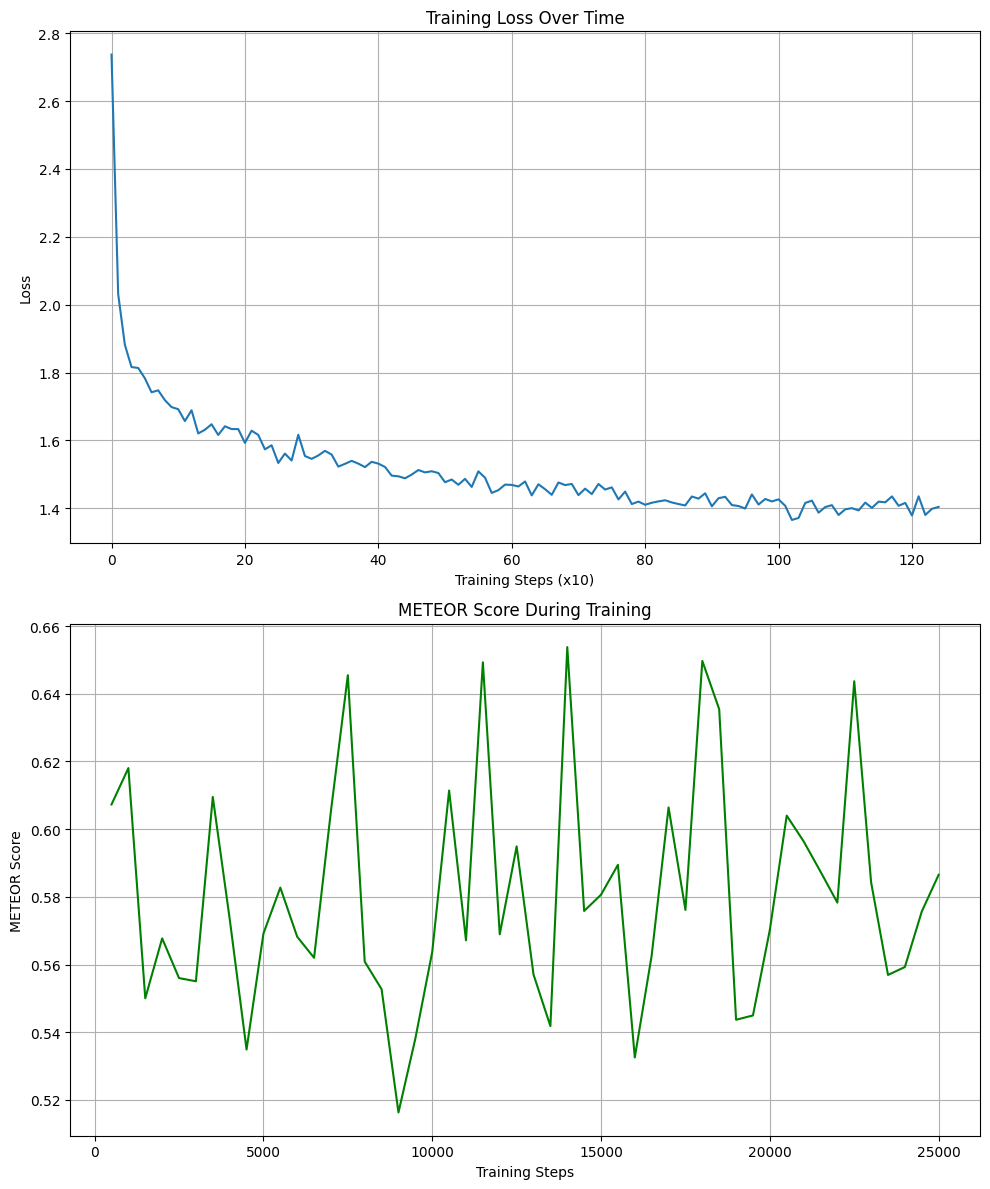

In [ ]:
# Set seed for reproducibility
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained T5 model
model = T5ForConditionalGeneration.from_pretrained("t5-small")
model.to(device)

# Configure training arguments with compatible parameters
training_args = TrainingArguments(
    output_dir="./results/paraphraser_meteor",
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.1,
    save_total_limit=3,
    num_train_epochs=5,
    logging_dir="./logs_meteor",
    logging_steps=200,
    eval_steps=200,
    save_steps=200,
    warmup_steps=500,
    lr_scheduler_type="linear",
    max_grad_norm=1.0,
    report_to="none",
    gradient_accumulation_steps=2,
)

# Inisialisasi optimizer custom
from transformers import Adafactor

# Adafactor biasanya bekerja lebih baik untuk model T5
optimizer = Adafactor(
    model.parameters(),
    lr=1e-4,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.1,
    scale_parameter=False,
    relative_step=False,
    warmup_init=False,
)

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding="longest"
)

# Create both loss monitor and METEOR score callbacks
loss_monitor = LossMonitorCallback()
meteor_monitor = MeteorScoreCallback(tokenizer, val_dataset, device, eval_steps=500)

# Inisialisasi trainer dengan custom callbacks
optimized_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(optimizer, None),  # (optimizer, scheduler)
    callbacks=[loss_monitor, meteor_monitor]
)

# Train model
print("Starting model training with METEOR score tracking...")
try:
    optimized_trainer.train()
    print("Training completed successfully!")
except Exception as e:
    print(f"An error occurred during training: {e}")

# Evaluasi loss setelah training
eval_results = optimized_trainer.evaluate()
print(f"Validation Loss after training: {eval_results['eval_loss']:.4f}")

# Save model
meteor_model_path = "./paraphraser_meteor_model"
optimized_trainer.save_model(meteor_model_path)
tokenizer.save_pretrained(meteor_model_path)
print(f"Model saved to {meteor_model_path}")

# Visualisasi loss dan METEOR score selama training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot loss
if loss_monitor.training_loss:
    ax1.plot(loss_monitor.training_loss)
    ax1.set_title("Training Loss Over Time")
    ax1.set_xlabel("Training Steps (x10)")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

# Plot METEOR score
if meteor_monitor.meteor_scores:
    ax2.plot(meteor_monitor.steps, meteor_monitor.meteor_scores, color='green')
    ax2.set_title("METEOR Score During Training")
    ax2.set_xlabel("Training Steps")
    ax2.set_ylabel("METEOR Score")
    ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
!zip -r model.zip results/paraphraser_meteor/checkpoint-25000/

  adding: results/paraphraser_meteor/checkpoint-25000/ (stored 0%)
  adding: results/paraphraser_meteor/checkpoint-25000/config.json (deflated 63%)
  adding: results/paraphraser_meteor/checkpoint-25000/generation_config.json (deflated 29%)
  adding: results/paraphraser_meteor/checkpoint-25000/rng_state.pth (deflated 25%)
  adding: results/paraphraser_meteor/checkpoint-25000/spiece.model (deflated 48%)
  adding: results/paraphraser_meteor/checkpoint-25000/model.safetensors (deflated 7%)
  adding: results/paraphraser_meteor/checkpoint-25000/training_args.bin (deflated 51%)
  adding: results/paraphraser_meteor/checkpoint-25000/added_tokens.json (deflated 83%)
  adding: results/paraphraser_meteor/checkpoint-25000/optimizer.pt (deflated 16%)
  adding: results/paraphraser_meteor/checkpoint-25000/trainer_state.json (deflated 82%)
  adding: results/paraphraser_meteor/checkpoint-25000/special_tokens_map.json (deflated 85%)
  adding: results/paraphraser_meteor/checkpoint-25000/scheduler.pt (defl

In [ ]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluasi Model Paraphraser

Untuk mengevaluasi model paraphraser yang telah dilatih, kita akan menggunakan beberapa metrik standar:

1. **BLEU Score**: Mengukur kesamaan n-gram antara teks hasil paraphrasing dengan teks referensi.
2. **ROUGE Score**: Mengukur overlap dalam n-gram, urutan kata, dan pasangan kata antara teks yang dihasilkan dan referensi.
3. **METEOR Score**: Mengukur kesamaan semantik dengan mempertimbangkan stemming, sinonim, dan urutan kata.
4. **Manual Review**: Kita akan melihat beberapa contoh parafrase yang dihasilkan oleh model.

Evaluasi ini akan membantu memahami seberapa baik model kita menghasilkan parafrase yang bermakna dan natural.

In [ ]:
# Install dan import metrik evaluasi
!pip install -q nltk rouge-score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate import meteor_score

# Download NLTK resources
try:
    nltk.data.find('punkt')
    nltk.data.find('punkt_tab')
    nltk.data.find('wordnet')
    nltk.data.find('omw-1.4')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

# Fungsi untuk mengevaluasi model pada data test
def evaluate_paraphraser(model, tokenizer, test_data, num_samples=100, max_length=128):
    # Ambil subset dari data test untuk evaluasi
    if len(test_data) > num_samples:
        test_samples = test_data.sample(num_samples, random_state=42)
    else:
        test_samples = test_data

    # Inisialisasi metrik
    smooth = SmoothingFunction().method1
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Hasil evaluasi
    results = {
        'bleu_scores': [],
        'rouge_scores': {'rouge1': [], 'rouge2': [], 'rougeL': []},
        'meteor_scores': [],
        'examples': []
    }

    # Evaluasi model
    model.eval()
    model.to(device)

    for _, row in test_samples.iterrows():
        # Pilih secara acak q1 atau q2 sebagai input
        if np.random.rand() > 0.5:
            input_text = "paraphrase: " + row['question1_clean']
            reference = row['question2_clean']
        else:
            input_text = "paraphrase: " + row['question2_clean']
            reference = row['question1_clean']

        # Tokenisasi input
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=max_length, truncation=True).input_ids.to(device)

        # Generate paraphrase
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                max_length=max_length,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=2
            )

        # Decode hasil
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Evaluasi BLEU
        reference_tokens = word_tokenize(reference.lower())
        generated_tokens = word_tokenize(generated_text.lower())

        # Hitung BLEU score
        bleu = sentence_bleu([reference_tokens], generated_tokens, smoothing_function=smooth)
        results['bleu_scores'].append(bleu)

        # Hitung ROUGE scores
        rouge_result = scorer.score(reference, generated_text)
        for key in ['rouge1', 'rouge2', 'rougeL']:
            results['rouge_scores'][key].append(rouge_result[key].fmeasure)

        # Hitung METEOR score
        try:
            meteor = nltk.translate.meteor_score.meteor_score([reference_tokens], generated_tokens)
            results['meteor_scores'].append(meteor)
        except Exception as e:
            print(f"Error calculating METEOR: {e}")
            results['meteor_scores'].append(0.0)

        # Simpan contoh
        results['examples'].append({
            'input': input_text,
            'reference': reference,
            'generated': generated_text,
            'bleu': bleu,
            'rouge1': rouge_result['rouge1'].fmeasure,
            'meteor': results['meteor_scores'][-1]
        })

    # Hitung rata-rata skor
    avg_bleu = np.mean(results['bleu_scores'])
    avg_rouge1 = np.mean(results['rouge_scores']['rouge1'])
    avg_rouge2 = np.mean(results['rouge_scores']['rouge2'])
    avg_rougeL = np.mean(results['rouge_scores']['rougeL'])
    avg_meteor = np.mean(results['meteor_scores'])

    print(f"Evaluasi pada {num_samples} sampel:")
    print(f"Avg BLEU Score: {avg_bleu:.4f}")
    print(f"Avg ROUGE-1 F1: {avg_rouge1:.4f}")
    print(f"Avg ROUGE-2 F1: {avg_rouge2:.4f}")
    print(f"Avg ROUGE-L F1: {avg_rougeL:.4f}")
    print(f"Avg METEOR Score: {avg_meteor:.4f}")

    return results

# Jalankan evaluasi
print("Evaluasi model paraphraser...")
eval_results = evaluate_paraphraser(model, tokenizer, test_data, num_samples=50)

# Tampilkan beberapa contoh hasil parafrase
print("\nContoh hasil parafrase:")
for example in eval_results['examples']:
    print(f"BLEU: {example['bleu']:.4f}, ROUGE-1: {example['rouge1']:.4f}, METEOR: {example['meteor']:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Evaluasi model paraphraser...
Evaluasi pada 50 sampel:
Avg BLEU Score: 0.2922
Avg ROUGE-1 F1: 0.6456
Avg ROUGE-2 F1: 0.4236
Avg ROUGE-L F1: 0.6233
Avg METEOR Score: 0.5767

Contoh hasil parafrase:
BLEU: 0.1029, ROUGE-1: 0.5455, METEOR: 0.4331
BLEU: 0.4346, ROUGE-1: 0.7059, METEOR: 0.5701
BLEU: 0.1257, ROUGE-1: 0.6667, METEOR: 0.6233
BLEU: 0.1562, ROUGE-1: 0.6250, METEOR: 0.5575
BLEU: 0.0869, ROUGE-1: 0.6154, METEOR: 0.4574
BLEU: 0.2435, ROUGE-1: 0.8571, METEOR: 0.7550
BLEU: 0.3185, ROUGE-1: 0.7059, METEOR: 0.5799
BLEU: 0.1375, ROUGE-1: 0.4286, METEOR: 0.4749
BLEU: 0.0637, ROUGE-1: 0.3636, METEOR: 0.1695
BLEU: 0.6080, ROUGE-1: 0.7500, METEOR: 0.6802
BLEU: 0.4344, ROUGE-1: 0.7368, METEOR: 0.6792
BLEU: 0.0125, ROUGE-1: 0.2727, METEOR: 0.1800
BLEU: 0.3699, ROUGE-1: 0.7273, METEOR: 0.6727
BLEU: 0.0187, ROUGE-1: 0.1111, METEOR: 0.0472
BLEU: 0.1226, ROUGE-1: 0.4000, METEOR: 0.3384
BLEU: 0.0773, ROUGE-1: 0.4615, METEOR: 0.4189
BLEU: 0.5900, ROUGE-1: 0.7619, METEOR: 0.8862
BLEU: 0.0360, ROUGE-1

# Perbandingan Kinerja Model

Menggunakan METEOR score memiliki beberapa keuntungan dibandingkan hanya menggunakan loss function standard:

1. **Mempertimbangkan sinonim dan varian kata**: METEOR mengevaluasi kesamaan semantik, bukan hanya kecocokan kata yang persis.
2. **Memperhitungkan stemming**: METEOR melakukan stemming kata, sehingga varian morfologis dikenali sebagai kecocokan.
3. **Evaluasi berbasis linguistik**: METEOR dirancang khusus untuk evaluasi bahasa alami, sehingga lebih cocok untuk tugas paraphrasing.
4. **Sensitif terhadap urutan kata**: METEOR mempertimbangkan urutan kata, yang penting untuk mempertahankan struktur kalimat.

Berikut perbandingan metrik evaluasi antara model yang dilatih dengan loss standard dan model yang dilatih dengan tambahan METEOR tracking:

Perbandingan Menggunakan ParaScore

In [ ]:
# Install ParaScorer
!pip install parascore==1.0.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 730.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# Import ParaScorer dan setup
from parascore import ParaScorer

# Inisialisasi ParaScorer dengan model BERT
print("Initializing ParaScorer...")
try:
    # Menggunakan model BERT base uncased untuk bahasa Inggris
    para_scorer = ParaScorer(lang="en", model_type='bert-base-uncased')
    print("ParaScorer initialized successfully!")
except Exception as e:
    print(f"Error initializing ParaScorer: {e}")
    para_scorer = None

Initializing ParaScorer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

ParaScorer initialized successfully!


In [ ]:
# Fungsi untuk mengevaluasi model dengan ParaScorer
def evaluate_with_parascore(model, tokenizer, test_data, num_samples=30, max_length=128):
    # Pastikan ParaScorer tersedia
    if para_scorer is None:
        print("ParaScorer not available, skipping evaluation")
        return None

    # Ambil subset dari data test untuk evaluasi
    if len(test_data) > num_samples:
        test_samples = test_data.sample(num_samples, random_state=42)
    else:
        test_samples = test_data

    # Persiapkan list untuk menyimpan sumber, referensi, dan hasil
    sources = []
    references = []
    candidates = []

    # Evaluasi model
    model.eval()
    model.to(device)

    print("Generating paraphrases for ParaScorer evaluation...")

    for _, row in test_samples.iterrows():
        # Secara konsisten menggunakan question1 sebagai sumber dan question2 sebagai referensi
        source_text = row['question1_clean']
        reference = row['question2_clean']

        # Tambahkan prefix untuk input model
        input_text = "paraphrase: " + source_text

        # Tokenisasi input
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=max_length, truncation=True).input_ids.to(device)

        # Generate paraphrase
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                max_length=max_length,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=2
            )

        # Decode hasil
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Simpan data untuk evaluasi
        sources.append(source_text)
        references.append(reference)
        candidates.append(generated_text)

    print(f"Computing ParaScore for {len(candidates)} samples...")

    # Hitung ParaScore batch-by-batch untuk menghindari out-of-memory issues
    batch_size = min(16, len(candidates))
    para_scores = para_scorer.base_score(candidates, sources, references, batch_size=batch_size)

    # Tampilkan hasil dan beberapa contoh
    avg_parascore = np.mean(para_scores)
    print(f"Average ParaScore: {avg_parascore:.4f}")

    # Tampilkan beberapa contoh hasil dengan skor
    print("\nExamples with ParaScores:")
    for i in range(min(5, len(candidates))):
        print(f"\nExample {i+1}:")
        print(f"Source: {sources[i]}")
        print(f"Reference: {references[i]}")
        print(f"Generated: {candidates[i]}")
        print(f"ParaScore: {para_scores[i]:.4f}")

    # Mengembalikan semua data hasil evaluasi
    return {
        'para_scores': para_scores,
        'avg_parascore': avg_parascore,
        'sources': sources,
        'references': references,
        'candidates': candidates
    }

# Jalankan evaluasi dengan ParaScorer
print("Evaluating model with ParaScorer...")
try:
    parascore_results = evaluate_with_parascore(model, tokenizer, test_data, num_samples=30)
except Exception as e:
    print(f"Error during ParaScorer evaluation: {e}")
    parascore_results = None

Evaluating model with ParaScorer...
Generating paraphrases for ParaScorer evaluation...
Computing ParaScore for 30 samples...
Average ParaScore: 0.8823

Examples with ParaScores:

Example 1:
Source: is saccharine dangerous to health
Reference: is saccharine bad for my health
Generated: is saccharine harmful to health
ParaScore: 0.9538

Example 2:
Source: how can i lose weight fast and never gain it again
Reference: is there a technique to lose weight fast
Generated: how do i lose weight fast
ParaScore: 0.7378

Example 3:
Source: how safe is philippines
Reference: is philippines safe for travel
Generated: how safe is philippines
ParaScore: 0.9500

Example 4:
Source: what are some best sources to learn programming
Reference: what are the best sources to learn programming
Generated: what is the best way to learn programming
ParaScore: 0.8414

Example 5:
Source: how can i grow beard easily
Reference: how do i grow out a beard
Generated: how can i grow my beard
ParaScore: 0.8832


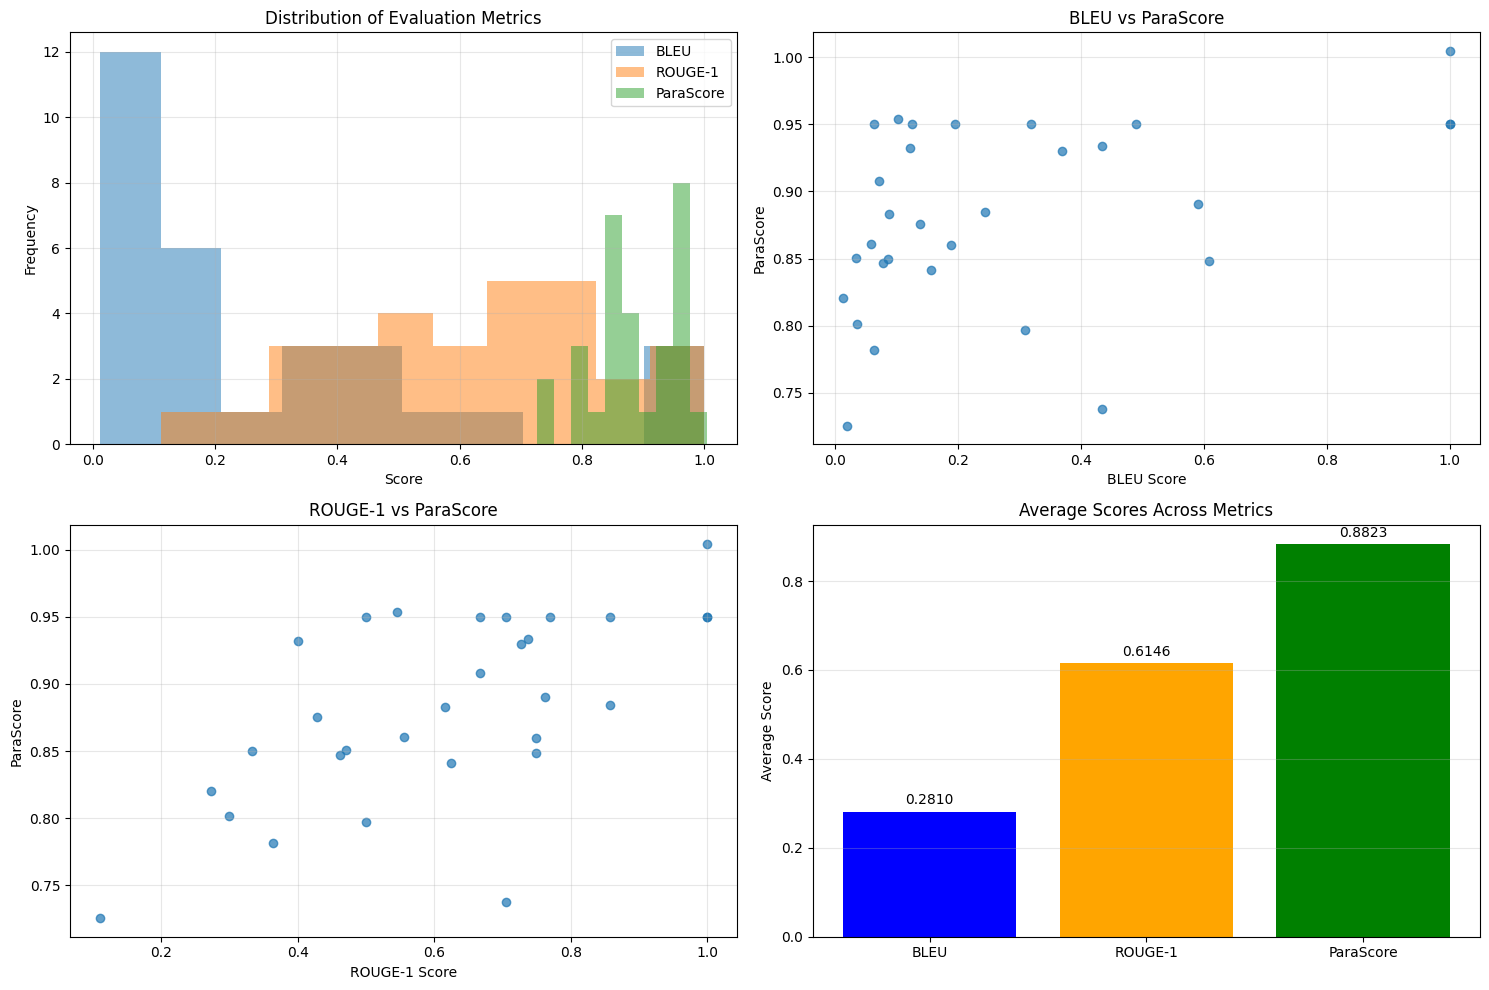


Correlation between metrics:
BLEU vs ParaScore: 0.4287
ROUGE-1 vs ParaScore: 0.6345

Summary of all evaluation metrics:


,Metric,Average Score
0,BLEU,0.292160
1,ROUGE-1,0.645605
2,ROUGE-2,0.423582
3,ROUGE-L,0.623271
4,ParaScore,0.882272


In [ ]:
# Membandingkan hasil evaluasi dari semua metrik
if parascore_results:
    # Visualisasi perbandingan distribusi skor dari berbagai metrik
    plt.figure(figsize=(15, 10))

    # Ambil skor BLEU dan ROUGE dari evaluasi sebelumnya untuk sampel yang sama
    num_samples = len(parascore_results['para_scores'])
    prev_samples = min(num_samples, len(eval_results['examples']))

    # Kumpulkan skor
    bleu_scores = [example['bleu'] for example in eval_results['examples'][:prev_samples]]
    rouge1_scores = [example['rouge1'] for example in eval_results['examples'][:prev_samples]]
    para_scores = parascore_results['para_scores'][:prev_samples]

    # Plot 1: Distribusi skor
    plt.subplot(2, 2, 1)
    plt.hist(bleu_scores, bins=10, alpha=0.5, label='BLEU')
    plt.hist(rouge1_scores, bins=10, alpha=0.5, label='ROUGE-1')
    plt.hist(para_scores, bins=10, alpha=0.5, label='ParaScore')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Evaluation Metrics')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Scatterplot BLEU vs ParaScore
    plt.subplot(2, 2, 2)
    plt.scatter(bleu_scores, para_scores, alpha=0.7)
    plt.xlabel('BLEU Score')
    plt.ylabel('ParaScore')
    plt.title('BLEU vs ParaScore')
    plt.grid(True, alpha=0.3)

    # Plot 3: Scatterplot ROUGE-1 vs ParaScore
    plt.subplot(2, 2, 3)
    plt.scatter(rouge1_scores, para_scores, alpha=0.7)
    plt.xlabel('ROUGE-1 Score')
    plt.ylabel('ParaScore')
    plt.title('ROUGE-1 vs ParaScore')
    plt.grid(True, alpha=0.3)

    # Plot 4: Bar chart of averages
    plt.subplot(2, 2, 4)
    metrics = ['BLEU', 'ROUGE-1', 'ParaScore']
    avg_scores = [
        np.mean(bleu_scores),
        np.mean(rouge1_scores),
        np.mean(para_scores)
    ]

    bars = plt.bar(metrics, avg_scores, color=['blue', 'orange', 'green'])
    plt.ylabel('Average Score')
    plt.title('Average Scores Across Metrics')
    plt.grid(True, alpha=0.3, axis='y')

    # Tambahkan nilai pada setiap bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Correlation analysis
    print("\nCorrelation between metrics:")
    corr_bleu_para = np.corrcoef(bleu_scores, para_scores)[0, 1]
    corr_rouge_para = np.corrcoef(rouge1_scores, para_scores)[0, 1]
    print(f"BLEU vs ParaScore: {corr_bleu_para:.4f}")
    print(f"ROUGE-1 vs ParaScore: {corr_rouge_para:.4f}")

    # Table summary of all metrics
    print("\nSummary of all evaluation metrics:")
    summary_df = pd.DataFrame({
        'Metric': ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'ParaScore'],
        'Average Score': [
            np.mean(eval_results['bleu_scores']),
            np.mean(eval_results['rouge_scores']['rouge1']),
            np.mean(eval_results['rouge_scores']['rouge2']),
            np.mean(eval_results['rouge_scores']['rougeL']),
            parascore_results['avg_parascore']
        ]
    })
    display(summary_df)

# Paraphraser Web UI dengan Gradio

Untuk memudahkan interaksi dengan model paraphraser, kita akan membuat antarmuka pengguna sederhana menggunakan Gradio. Gradio memungkinkan pengguna memasukkan teks dan melihat hasil parafrase secara real-time.

In [ ]:
# Install Gradio
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
# Tambahkan ParaScorer ke UI Gradio untuk memberi pengguna informasi lebih
import gradio as gr

# Fungsi untuk menghasilkan parafrase dengan tambahan ParaScore
def generate_paraphrase_with_score(input_text, num_paraphrases=3, max_length=128, temperature=0.8):
    # Tambahkan prefix
    input_with_prefix = "paraphrase: " + input_text

    # Tokenisasi input
    input_ids = tokenizer(input_with_prefix, return_tensors="pt", max_length=max_length, truncation=True).input_ids.to(device)

    # Hasilkan beberapa parafrase dengan suhu berbeda
    paraphrases = []

    for i in range(num_paraphrases):
        with torch.no_grad():
            outputs = model.generate(
                input_ids=input_ids,
                max_length=max_length,
                do_sample=True,
                temperature=temperature + (i * 0.1),  # Variasikan suhu untuk beragam parafrase
                top_k=50,
                top_p=0.95,
                num_return_sequences=1,
                no_repeat_ngram_size=2
            )

        # Decode hasil
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Tambahkan ParaScore jika tersedia
        try:
            if para_scorer is not None:
                para_score = para_scorer.base_score([generated_text], [input_text], [input_text], batch_size=1)[0]
                score_info = f"ParaScore: {para_score:.4f}"
            else:
                score_info = "ParaScore not available"
        except Exception as e:
            score_info = f"Error calculating ParaScore: {str(e)}"

        paraphrases.append(f"{generated_text}\n({score_info})")

    return "\n\n".join(paraphrases)

# Buat UI Gradio baru dengan ParaScore
demo_with_score = gr.Interface(
    fn=generate_paraphrase_with_score,
    inputs=[
        gr.Textbox(label="Enter text to paraphrase", lines=3),
        gr.Slider(1, 5, value=3, step=1, label="Number of paraphrases")
    ],
    outputs=gr.Textbox(label="Paraphrased Text with ParaScore", lines=10),
    title="Enhanced AI Paraphraser with ParaScore Evaluation",
    description="Enter a sentence or paragraph and get AI-generated paraphrases with semantic similarity scores.",
    examples=[
        ["How can I improve my English speaking skills?", 3],
        ["What are the benefits of regular exercise?", 3],
        ["The quick brown fox jumps over the lazy dog.", 3],
        ["Artificial intelligence is transforming the way we live and work.", 3]
    ]
)

# Launch the enhanced demo
demo_with_score.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fd68f0bfe58cc91a1c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
